# imports

In [56]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
import logging
import multiprocessing

In [57]:
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

# loading Dataset

In [111]:
INPUT_PATH = '/Users/maedeh/Desktop/demand_project/shoofer-demand-prediction/data/labels.parquet'
OUTPUT_PATH = '/Users/maedeh/Desktop/demand_project/shoofer-demand-prediction/data/prophet_predict.parquet'

In [4]:
def load_data(path):
    dataset = pd.read_parquet(path, engine = 'pyarrow') 
    return dataset

In [5]:
rides_df = load_data(INPUT_PATH)
rides_df.head()

,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0


# aggregating_labels 

In [6]:
def aggregating_labels(rides_df):
    location_labels_df = pd.pivot_table(rides_df, values ='Demand', index =['Date'], columns =['Location'])
    prefix = 'Location_'
    location_labels_df = location_labels_df.add_prefix(prefix)
    location_labels_df = location_labels_df.reset_index().rename_axis('index')
    return location_labels_df

In [7]:
location_labels_df = aggregating_labels(rides_df)
print(f'location_labels_df shape : {location_labels_df.shape}')
location_labels_df.head()

location_labels_df shape : (120, 263)


Location,Date,Location_1,Location_2,Location_3,Location_4,Location_5,Location_6,Location_7,Location_8,Location_9,...,Location_256,Location_257,Location_258,Location_259,Location_260,Location_261,Location_262,Location_263,Location_264,Location_265
index,,,,,,,,,,,,,,,,,,,,,
0,2023-01-01,40.0,0.0,0.0,174.0,3.0,1.0,126.0,1.0,0.0,...,125.0,5.0,5.0,1.0,48.0,510.0,837.0,1942.0,1176.0,124.0
1,2023-01-02,31.0,0.0,2.0,32.0,2.0,3.0,39.0,0.0,2.0,...,13.0,2.0,4.0,1.0,15.0,432.0,758.0,1328.0,1110.0,59.0
2,2023-01-03,27.0,0.0,2.0,51.0,2.0,1.0,48.0,0.0,1.0,...,17.0,2.0,5.0,0.0,14.0,338.0,1344.0,1746.0,1249.0,54.0
3,2023-01-04,7.0,0.0,1.0,43.0,2.0,1.0,38.0,0.0,1.0,...,17.0,2.0,4.0,5.0,22.0,432.0,1479.0,1967.0,1294.0,51.0
4,2023-01-05,15.0,0.0,2.0,42.0,2.0,5.0,49.0,1.0,3.0,...,12.0,2.0,3.0,4.0,20.0,436.0,1552.0,2035.0,1393.0,45.0


# Prophet MODEL

## train 

In [14]:
train_size_ratio = 0.12

In [15]:
def split_data(location_labels_df, location, train_size_ratio):
    train_end_date = int(len(location_labels_df) * train_size_ratio)
    train_data = location_labels_df.loc[:train_end_date,['Date',location]]
    test_data = location_labels_df.loc[train_end_date:, ['Date',location]]
    train_data.columns = ['ds','y']
    test_data.columns = ['ds','y']
    return (train_data, test_data)

In [33]:
def prophet_forecast(train_data, test_data):
    history = train_data
    predictions = []
    for t in range(len(test_data)):
        model = Prophet()
        model.fit(history)
        ds = model.make_future_dataframe(periods=1)
        output = model.predict(ds)
        predictions.append(int(output.yhat.iloc[-1]))
        obs = test_data.iloc[[t],:]
        history = pd.concat([history, obs], axis = 0).reset_index(drop=True)

    return (test_data.y, predictions)


### train and predict for all locationIDs


In [143]:
def predict_all_location(location_labels_df, train_size_ratio):
    
    predict_date_location = {}
    test_date_location = {}
    column = location_labels_df.columns
    
    for loc in column[1:]:
        
        train_data, test_data = split_data (location_labels_df, loc, train_size_ratio)
        result = prophet_forecast(train_data, test_data)
        test_date_location[loc] = result[0]
        predict_date_location[loc] = result[1]
    
        
    test_date_location = pd.DataFrame(test_date_location).reset_index(drop=True)
    predict_date_location = pd.DataFrame(predict_date_location).reset_index(drop=True)
    return (test_date_location, predict_date_location)

In [ ]:
test_date_location, predict_date_location = predict_all_location(location_labels_df, train_size_ratio)

## evaluation

In [20]:
def mape(test_data, predictions):
  mape = mean_absolute_percentage_error(test_data, predictions)
  return mape

In [19]:
def rmse(test_data, predictions):
  rmse = sqrt(mean_squared_error(test_data, predictions))
  return rmse

In [137]:
def mape_rmse_all_location(test_date_location,predict_date_location):
    mape_error = {col: mape(test_date_location[col],predict_date_location[col]) for col in test_date_location.columns}
    rmse_error = {col: rmse(test_date_location[col],predict_date_location[col]) for col in test_date_location.columns}
    all_loc_mape = pd.DataFrame.from_dict(mape_error, orient='index')
    all_loc_rmse = pd.DataFrame.from_dict(rmse_error, orient='index')
    return (all_loc_mape, all_loc_rmse)

In [138]:
all_loc_mape, all_loc_rmse = mape_rmse_all_location(test_date_location,predict_date_location)

### plots

In [139]:
def plot_high_demand_error(all_loc_rmse,all_loc_mape):
    plt.rcParams['figure.figsize'] = (50, 30)
    index_high_demand = location_labels_df.iloc[:,1:].sum().sort_values(ascending=False).index[:51]
    
    plt.subplot(2,1,1)
    plt.plot(range(1,52), all_loc_rmse.loc[index_high_demand], linewidth=6)
    plt.title('RMSE of High Demand LocationID', fontsize=45)
    plt.ylabel('rmse', fontsize=35)
    plt.xlabel('LocationID', fontsize=35)
    plt.xticks(range(1,52), list(index_high_demand), rotation=45)
    plt.tick_params(axis='both', labelsize=25)
    
    
    plt.subplot(2,1,2)
    plt.plot(range(1,52), all_loc_mape.loc[index_high_demand], color='orange', linewidth=6)
    plt.title('MAPE of High Demand LocationID', fontsize=45)
    plt.ylabel('mape', fontsize=35)
    plt.xlabel('LocationID', fontsize=35)
    plt.xticks(range(1,52), list(index_high_demand), rotation=45)
    plt.tick_params(axis='both', labelsize=25)
    plt.tight_layout()
    
    plt.show()

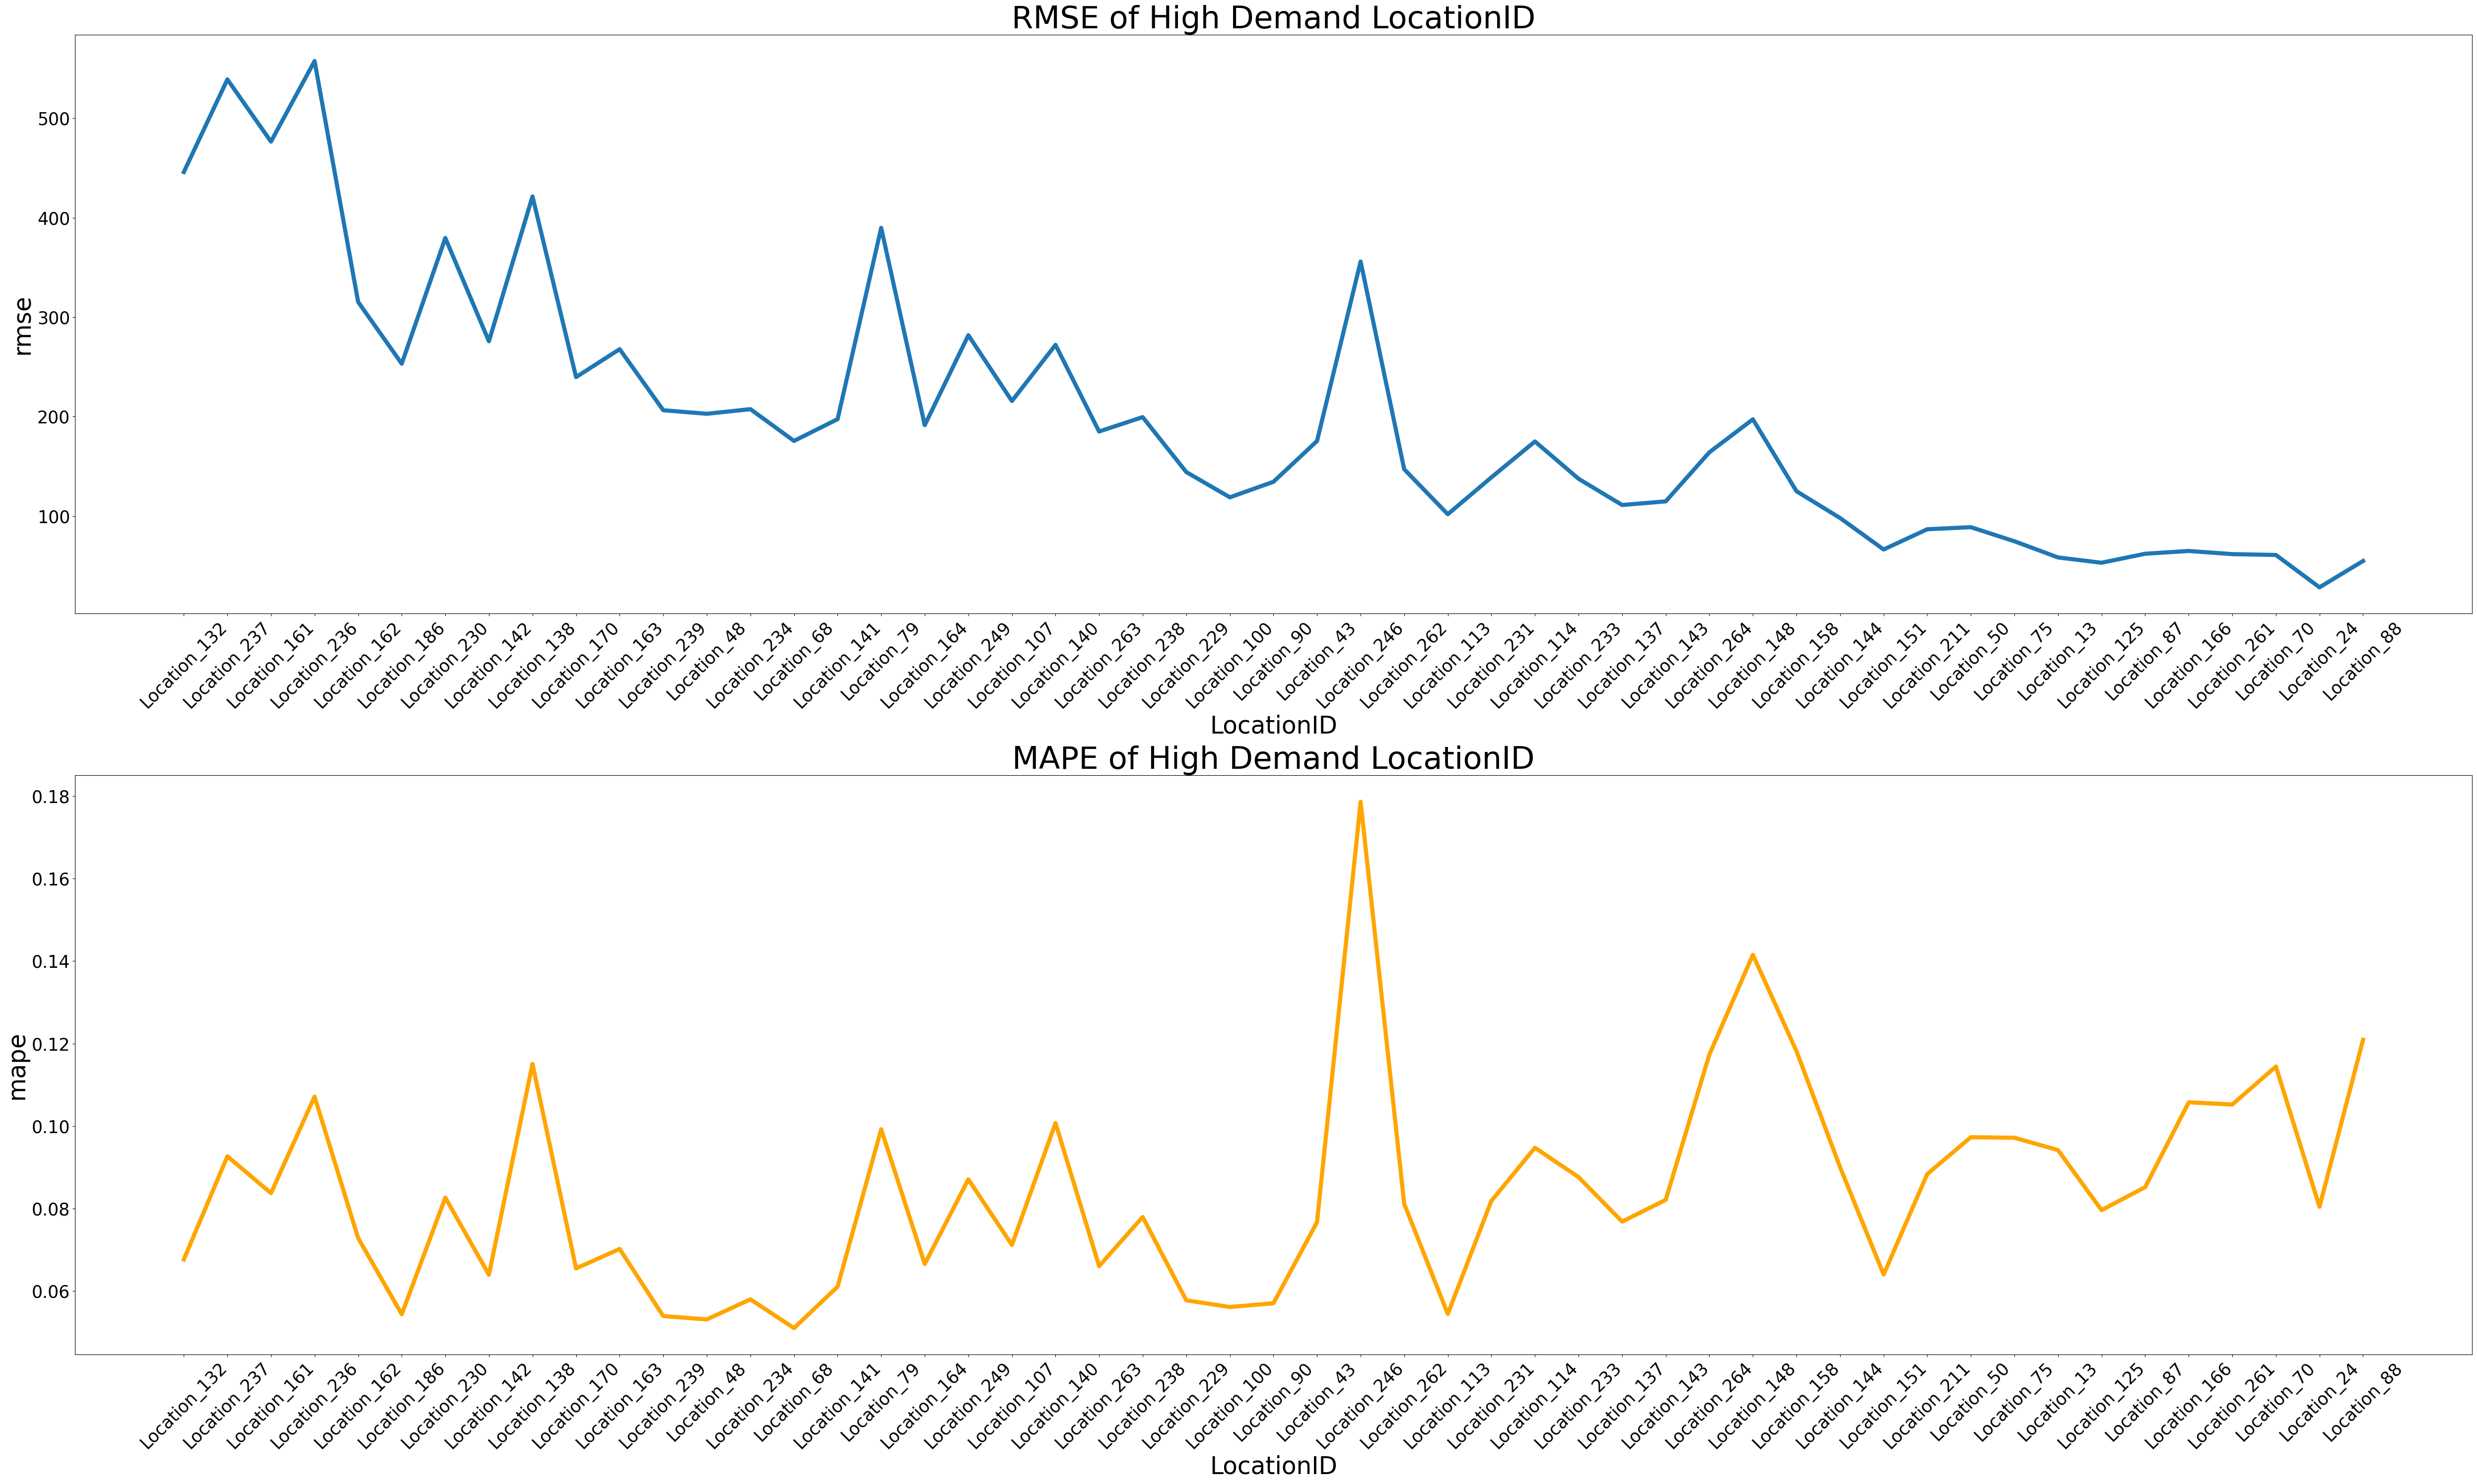

In [140]:
plot_high_demand_error(all_loc_rmse, all_loc_mape)

In [141]:
def evaluation(test_date_location, predict_date_location):
    index_high_demand = location_labels_df.iloc[:,1:].sum().sort_values(ascending=False).index[:51]
    predict_data_vec = predict_date_location[index_high_demand].to_numpy().reshape((1,-1))
    test_data_vec = test_date_location[index_high_demand].to_numpy().reshape((1,-1))
    mape_error = mape(test_data_vec,predict_data_vec)
    rmse_error = rmse(test_data_vec,predict_data_vec)
    print(f'mape of high demand locations: {mape_error}')
    print(f'rmse of high demand locations: {rmse_error}')

In [142]:
evaluation(test_date_location, predict_date_location)

mape of high demand locations: 0.08445077054925756
rmse of high demand locations: 236.6602364521194


# Save file

In [144]:
def reshape_output(rides_df, predicted_date_location):
    dataset = rides_df.sort_values(['Date','Location'])[14*262:].reset_index(drop = True)
    dataset['prophet_predicted_demand'] = predicted_date_location.to_numpy().reshape((-1,1))
    dataset.drop(columns = ['Demand'], inplace = True)
    output_dataset = dataset.sort_values(['Location','Date']).reset_index(drop = True)
    return output_dataset

In [145]:
predicted_data = reshape_output(rides_df, predict_date_location)
print(f'predicted data shape: {predicted_data.shape}')
predicted_data.head()

predicted data shape: (27772, 3)


,Location,Date,prophet_predicted_demand
0,1,2023-01-15,11
1,1,2023-01-16,11
2,1,2023-01-17,6
3,1,2023-01-18,1
4,1,2023-01-19,5


In [146]:
def save_val_predicted(dataset, path):
    labels_df = dataset.to_parquet(path, index=False)

In [147]:
save_val_predicted(predicted_data, OUTPUT_PATH)